# Analyzing Police Violence in Canada with Python

* Firs we'll import a few standard packages

    * Numpy is the go to package for handling arrays (multidmensional data)
    * Pandas is a great tool for handling tabular datasets
    * Datetime alows us to format and interpret dates
    * matplotlib alows us to make all sort of visualizatons
            * %matplotlib notebook allows us to make our visualizations interactive
            
## This dataset comes from the CBC:
https://newsinteractives.cbc.ca/longform-custom/deadly-force


## Learning Objectives (Geocoding Police Violence):
* Get and introduction using open source GIS (Python) 
* Import, Join, and Plot tabular data
* Geocode addresses
* Query records
* Produce a web map



In [1]:
import geopy
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

## Lets look at the incident records

* We'll use a Pandas to import the data.  Pandas stores records as a DataFrame

### This data set includes some information about each police killing

* We have the postal code of the incident, province, municipality, along with the date and incident ID
* Pandas has all sorts of helpful funcitons, including parse_dates, which will automattially interpret date columns
* Calling the DataFrame will give us a quick look at the dataset

In [2]:
Incident = pd.read_csv('incident.csv',delimiter = ',',header = 0,parse_dates=['date'],index_col='id_incident')
Incident


,date,day_week,prov,city_town,postal_code,location_type
id_incident,,,,,,
1,2012-01-06,Fri,QC,Montreal,H3B 4W5,Urban
2,2012-01-11,Wed,AB,Onoway,T0E 1V0,Rural
3,2012-01-12,Thu,ON,Oakville,L6H 0G6,Urban
4,2012-02-03,Fri,ON,Toronto,M4C 1X5,Urban
5,2012-02-13,Mon,ON,Hamilton,L8K 5J4,Urban
...,...,...,...,...,...,...
500,2011-03-27,Sun,QC,Terrebonne,J6W 1H3,Urban
501,2010-10-21,Thu,QC,Cloutier,J0Z 1S0,Rural
502,2007-04-25,Wed,QC,Matagami,J0Y 2A0,Rural


## We also have data on the Victims and Police

* Notice the names have been redacted, this to to protect the privacy of the victims

* Calling .head() will print the first four rows and show us the column headers.

In [3]:
Victim = pd.read_csv('victim.csv',delimiter = ',',header = 0, index_col=['id_incident'])
Police = pd.read_csv('police.csv',delimiter = ',',header = 0, index_col=['id_incident'])
print(Victim.head())
# print()
print(Police.head())

            id_victim   Name   age gender       race ethnic_ancestry  \
id_incident                                                            
1             0001-V1  *****  34.0   Male      Other            Iran   
2             0002-V1  *****  49.0   Male    Unknown             NaN   
3             0003-V1  *****  43.0   Male  Caucasian             NaN   
4             0004-V1  *****  29.0   Male      Black             NaN   
5             0005-V1  *****  27.0   Male      Asian            Laos   

            immigrant_refugee_naturalized  \
id_incident                                 
1                                     Yes   
2                                 Unknown   
3                                 Unknown   
4                                 Unknown   
5                                     Yes   

                                        armed_type cause_death taser_deployed  \
id_incident                                                                     
1            Knif

# We can join all our data into one
* The id_incident is a unique identifier shared between each file, it can be used to match up records
* Then we can reset the index to the date of the indicent

## Therer are some duplicated values in the police record, I'll have to investigate further before including that.

In [4]:
AllData = Incident.join(Victim).reset_index().set_index('date',drop = False)
AllData

,id_incident,date,day_week,prov,city_town,postal_code,location_type,id_victim,Name,age,...,ethnic_ancestry,immigrant_refugee_naturalized,armed_type,cause_death,taser_deployed,injured_officer,excited_delirium,mentral_distress_disorder,substance_abuse,summary
date,,,,,,,,,,,,,,,,,,,,,
2012-01-06,1,2012-01-06,Fri,QC,Montreal,H3B 4W5,Urban,0001-V1,*****,34.0,...,Iran,Yes,"Knife, axe, other cutting instruments",Gunshot,No,Yes,No,Yes,Yes,Farshad Mohammadi was carrying a knife when he...
2012-01-11,2,2012-01-11,Wed,AB,Onoway,T0E 1V0,Rural,0002-V1,*****,49.0,...,NaN,Unknown,"Knife, axe, other cutting instruments",Gunshot,No,No,No,Unknown,Yes,RCMP called to an apartment complex in respons...
2012-01-12,3,2012-01-12,Thu,ON,Oakville,L6H 0G6,Urban,0003-V1,*****,43.0,...,NaN,Unknown,"Knife, axe, other cutting instruments",Gunshot,No,No,No,Unknown,Unknown,Kyle Newman intentionally and repeatedly struc...
2012-02-03,4,2012-02-03,Fri,ON,Toronto,M4C 1X5,Urban,0004-V1,*****,29.0,...,NaN,Unknown,"Knife, axe, other cutting instruments",Gunshot,No,No,No,Yes,No,"Michael Eligon, who had been involuntarily com..."
2012-02-13,5,2012-02-13,Mon,ON,Hamilton,L8K 5J4,Urban,0005-V1,*****,27.0,...,Laos,Yes,Vehicle,Gunshot,No,No,No,Yes,Unknown,"Police had a stolen van under surveillance, an..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-03-27,500,2011-03-27,Sun,QC,Terrebonne,J6W 1H3,Urban,0500-V1,*****,49.0,...,NaN,Unknown,Vehicle,Gunshot,No,Yes,No,No,No,Police responding to a robbery call at a gas s...
2010-10-21,501,2010-10-21,Thu,QC,Cloutier,J0Z 1S0,Rural,0501-V1,*****,34.0,...,NaN,No,"Knife, axe, other cutting instruments",Gunshot,No,No,No,Yes,Yes,√âric Pag√© had experienced a head injury at w...
2007-04-25,502,2007-04-25,Wed,QC,Matagami,J0Y 2A0,Rural,0502-V1,*****,43.0,...,NaN,Yes,"Knife, axe, other cutting instruments",Gunshot,No,No,No,Yes,No,Oumar Thiam moved to Quebec from Senegal with ...


## Lets look at a few specifics

* Pandas alows us to quickly calculate statiscis like averages.

* It also has special funcitons
    * .groupby() allows us to aggreagate data by different columns
    * .resample() alows us to up or downsample to by a specific interval (e.g. Yearly) 
* We can use matplotlib.pyplot (plt) to display our information

Mean Victim Age:  36.73186813186813



<IPython.core.display.Javascript object>


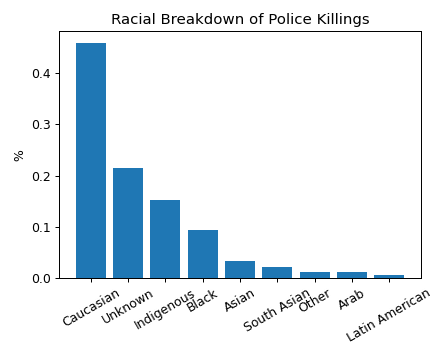

<IPython.core.display.Javascript object>


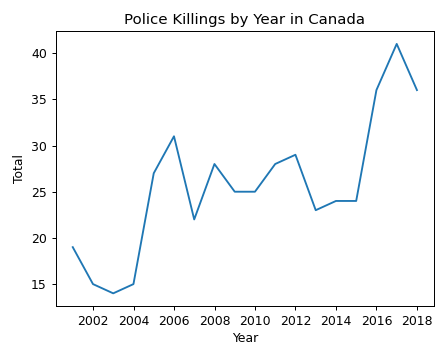

In [5]:
print('Mean Victim Age: ', AllData['age'].mean())
print()

Count = AllData.groupby('race')['Name'].count()
Percentage =(Count/Count.sum()).sort_values(ascending=False)
plt.figure(figsize=(5,4))
plt.bar(Percentage.index,Percentage.values)
plt.title('Racial Breakdown of Police Killings')
plt.ylabel('%')
plt.xticks(rotation=30)
plt.tight_layout()

# for a in Police.duplicated():
#     if a == True:
#         print(a)

Yearly = AllData.resample('Y').count()
plt.figure(figsize=(5,4))
plt.plot(Yearly.index,Yearly['postal_code'])
plt.title('Police Killings by Year in Canada')
plt.xlabel('Year')
plt.ylabel('Total')
plt.tight_layout()

## Lets use Geocoding to assign coordinates to the addresses

* Geocoding is a method of getting the x,y (latitude and longitude) coordinates for an entity based on a text description.

* We'll use the geopy package for this.  Check the docs if you're intersted in learning more:
https://geopy.readthedocs.io/en/stable/
    * Geocoding is a method for turning text descriptors into coordinates
    * geopy has multiple geocoder options.  You can use googel, bing, open streetmaps, etc.
    * We'll used Mapbox becsue you can get up to 15,000 free geocodes per month!
        * Mapbox is a webmapping platform that alows you to create and host webmaps
        * First, create an acount: https://www.mapbox.com/
        * Then you can get an API key for geocoding: https://account.mapbox.com/access-tokens/

### Once we have this we can import the MapBox geocoder and give it our API key 
* Then we can get to work!



In [6]:
from geopy.geocoders import MapBox
import folium
geolocator = MapBox(api_key="pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2ticGpkbXUxMHZyeTJzbDNpMGpjNWM5biJ9.B3AUQA9Qff8fo7gAo6NTvw")
# geolocator = MapBox(api_key="Enter Your API Key Here")

# Lets try a simple example first!  Type your address here and see what comes up!
Home = geolocator.geocode('2710 Fraser St. Vancouver, BC')
# Home = geolocator.geocode("Type your address here and see what comes up!")

print(Home)
print(Home.latitude,Home.longitude)

2710 Fraser Street, Vancouver, British Columbia V5T 2H7, Canada
49.260438 -123.088896


# It returns our full home address and we can print our lattitude and longitude



# Lets make a webmap, centered on our home address, displaying it as a blue dot

# We'll use a pacakge called Follium:
* First we'll crate a Map, we'll call it Home_Map.
* We'll set the location with our home lattitude and longitude, and set some other paramters.
* Then we'll add it to the map.
* The last step is to "call" the map, so it will display below

In [12]:


Home_Map = folium.Map(
    location=[Home.latitude,Home.longitude],
    zoom_start=11,
    tiles='Stamen Terrain'
)
Home_point=folium.CircleMarker(
        location=[Home.latitude,Home.longitude],
        radius=10,
        popup='Home!',
        fill_opacity = 1,
        fill=True,
        color='black',
        line_weight=.35,
        fill_color='blue'
    )

Home_point.add_to(Home_Map)

Home_Map

# We see it create an interactive map.  You can zoom and pan.  Click on your home and see what happens!

# Pretty cool right!?

# This is handy, but what if we have multiple points to plot?  It could get pretty cumbersome to create a bunch of circle markers.

# We can create a function to handle the details for us, and make it repeatable:
* "def" defines our function "plot_point()", which takes five "arguments":
    * Map: The map you're working with
    * X: lattitude
    * Y: longitude
    * Popup_Text: What do we want the popup to say?
    * Color: What colour do we want?
* Everything else will remain the same for every point, so we can set them and leave them as is.
* We run the CircleMarker() function and add it to the map with one statement.

In [9]:
def plot_point(Map,X,Y,Popup_Text,Color):
    folium.CircleMarker(
        location=[X,Y],
        radius=5,
        popup=Popup_Text,
        fill_opacity = .75,
        fill=True,
        color='black',
        line_weight=.15,
        fill_color=Color
    ).add_to(Map)

# So now that we've got this set up, lets explore the idea of geocoding a bit more!

# Geocoding requires specific information, otherwise, you may "confuse" the service

* Surrey or Victoria are well known cities in BC, but if you search for them withouth specifying "BC", you'll end up with the bigger, more populous cities that share their name

In [10]:
SurreyMap = folium.Map(
    location=[0,0],
    zoom_start=2,
    tiles='Stamen Terrain'
)

NotSurrey = geolocator.geocode('Surrey')
plot_point(SurreyMap,NotSurrey,'green')

Surrey = geolocator.geocode('Surrey, BC')
plot_point(SurreyMap,Surrey,'yellow')

Victoria = geolocator.geocode('Victoria')
plot_point(SurreyMap,NY,'blue')

NYC = geolocator.geocode('Victoria, BC')
plot_point(SurreyMap,NYC,'orange')

SurreyMap

TypeError: plot_point() missing 2 required positional arguments: 'Popup_Text' and 'Color'

# So how can we geocode this police violence dataset?

* This dataset has zipcodes, which are is a very specific identifier
    * We'll serach for each incident using the following search:
        * City + Zipccoe + Provicne
    * Some of our requests may fail! So we can try again with the city and province if so.
        * Try statements allow us to test if something works and skip the error if it doesn't.
        * If the City + Zipcode + Province request fails, maybe the zipcode had a typo?  We'll try just City + Province
        * If this fails too, we'll leave it blank and say the geocoding failed.

In [13]:
# # location = geolocator.geocode(Incident.iloc[1])
color_Scheme = {
    'Caucasian':'red',
    'Unknown':'grey',
    'Indigenous':'blue',
    'Black':'green',
    'Asian':'orange',
    'South Asian':'purple',
    'Other':'teal',
    'Arab':'pink',
    'Latin American':'yellow',
}
CanadaMap = folium.Map(
    location=[55,-91.5],
    zoom_start=4,
    tiles='Stamen Terrain'
)
AllData['latitude'] = np.nan
AllData['longitude'] = np.nan
AllData['geocoding_Notes'] = ''
# i = 1
# for postal_code,race in zip(AllData['postal_code'],AllData['race']):
success = True
for index, row in AllData.iterrows():
#     if i <3:
    try:
        g = geolocator.geocode(row['city_town']+' '+row['postal_code']+' '+ row['prov'])
        AllData.loc[AllData['postal_code']==row['postal_code'],
                    ['latitude','longitude']]=g.latitude,g.longitude
    except:
        try:
            g = geolocator.geocode(row['city_town']+' '+row['prov'])
            AllData.loc[AllData['postal_code']==row['postal_code'],
                        ['latitude','longitude','geocoding_Notes']]=g.latitude,g.longitude,'Just City'
            
        except:
            AllData.loc[AllData['postal_code']==row['postal_code'],
                        'geocoding_Notes']='Geocoding Failed'
            success = False
            pass
        pass
            
    if success == True:
        folium.CircleMarker(
            location=[g.latitude,g.longitude],
            radius=10,
            popup=row['race']+' '+ row['gender'] + ' '+ str(row['age']),
            fill_opacity = 1,
            fill=True,
            color='black',
            line_weight=.35,
            fill_color=color_Scheme[row['race']]
        ).add_to(CanadaMap)
    success = True
#     i +=1
CanadaMap
#         AllData.loc[AllData['postal_code']==postal_code,'longitude']=g.longitude
#         AllData.iloc[i]['longigude']=g.longitude
#         print(AllData.iloc[i]['latitude'])

# One of the records shows up in Massachusets.  This is obviously and issue.  Lets investigate a bit to try and see why?

* Its a typo.  Search this zipcode on the canada post webpage:https://www.canadapost.ca/cpo/mc/personal/postalcode/fpc.jsf
* It doesn't exist.  Say maybe its: V1T 7A3 instead?

In [15]:
CanadaMap.save('PoliceViolenceIncidents.html')

In [16]:
# AllData.loc[(AllData['race'] == 'V1T 7Z3'),'postal_code'] = 'V1T 7A3'
g = geolocator.geocode('V1T 7A3')
AllData.loc[AllData['postal_code']=='V1T 7Z3',
                    ['postal_code','latitude','longitude']]='V1T 7A3',g.latitude,g.longitude

# print(AllData.loc[((AllData['print(AllData.loc[((AllData['race'] == 'Indigenous')&(AllData['gender'] == 'Male')&(AllData['age'] == 35)
#                   ),['postal_code','city_town','prov']])'] == 'Indigenous')&(AllData['gender'] == 'Male')&(AllData['age'] == 35)
#                   ),['postal_code','city_town','prov']])

# Lets save our data so we don't have to geocode it everytime

In [17]:
AllData.to_csv('PoliceKillings.csv')

# Introduction using open source GIS (Python/QGIS) 
* Bulding off what was done in the last workshop
* Attendance of the first workshop isn't a pre-requisite of this one
* But the "output" of the first is the input of the second

# Learning Objectives:

* Import, Parse, and Plot tabular data
* Join Tabular & Spatial Data
* Reproject Coordinate Systems
* Data Normalization w/ Census Data
* Create an Infographic
* Create a heatmap (Maybe, if time allows??)

### GIS w/ Python: Resources:

https://gis.stackexchange.com/

https://geopandas.org/

https://matplotlib.org/


## First, Lets work with geopandas

* Geopandas is a geospatial exentson for pandas

In [18]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
# We import the Police Killings file we geocoded in Workshop #1
AllData= pd.read_csv('PoliceKillings.csv',parse_dates=['date'])
# We can then convert teh pandas dataframe into a geopandas "GeodataFrame"
police_Killings = gpd.GeoDataFrame(
    AllData,
    geometry=gpd.points_from_xy(AllData.longitude, AllData.latitude)
)
# We have to assign a coordinate system information associated with these lattitude/longigute coordinate
# epsg:4326 is a code for the WGS 1984 Datum, the coordinate system used by Mapbox's geodocer
police_Killings.crs = {'init' :'epsg:4326'}
police_Killings.head()

,date,id_incident,date.1,day_week,prov,city_town,postal_code,location_type,id_victim,Name,...,taser_deployed,injured_officer,excited_delirium,mentral_distress_disorder,substance_abuse,summary,latitude,longitude,geocoding_Notes,geometry
0,2012-01-06,1,2012-01-06,Fri,QC,Montreal,H3B 4W5,Urban,0001-V1,*****,...,No,Yes,No,Yes,Yes,Farshad Mohammadi was carrying a knife when he...,45.498173,-73.567157,NaN,POINT (-73.56716 45.49817)
1,2012-01-11,2,2012-01-11,Wed,AB,Onoway,T0E 1V0,Rural,0002-V1,*****,...,No,No,No,Unknown,Yes,RCMP called to an apartment complex in respons...,53.688760,-114.199440,NaN,POINT (-114.19944 53.68876)
2,2012-01-12,3,2012-01-12,Thu,ON,Oakville,L6H 0G6,Urban,0003-V1,*****,...,No,No,No,Unknown,Unknown,Kyle Newman intentionally and repeatedly struc...,43.477098,-79.702193,NaN,POINT (-79.70219 43.47710)
3,2012-02-03,4,2012-02-03,Fri,ON,Toronto,M4C 1X5,Urban,0004-V1,*****,...,No,No,No,Yes,No,"Michael Eligon, who had been involuntarily com...",43.687560,-79.321000,NaN,POINT (-79.32100 43.68756)
4,2012-02-13,5,2012-02-13,Mon,ON,Hamilton,L8K 5J4,Urban,0005-V1,*****,...,No,No,No,Yes,Unknown,"Police had a stolen van under surveillance, an...",43.219570,-79.794930,NaN,POINT (-79.79493 43.21957)


## Now we can import the provincial boundaries.

* They are in "Shapefile" format
* Note the layer has a different CRS
* Canadian Census Data usees the Lambert Conformal Conic Projection
    * This projectoin is ideally suited for displaying the entire country

In [19]:
# Now we can import a shapefile of Canadian Provincial boundaries!
Provinces = gpd.read_file('lpr_000b16a_e.shp')
print(Provinces.crs)

{'init': 'epsg:3347'}


## Layers need to be in the same coordinate system to match up properly!

* We can re-project the police_Killings layer using the .to_crs function to set the CRS to that of the Provinces
* Then we can make a map!

{'init': 'epsg:3347'}


C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<IPython.core.display.Javascript object>


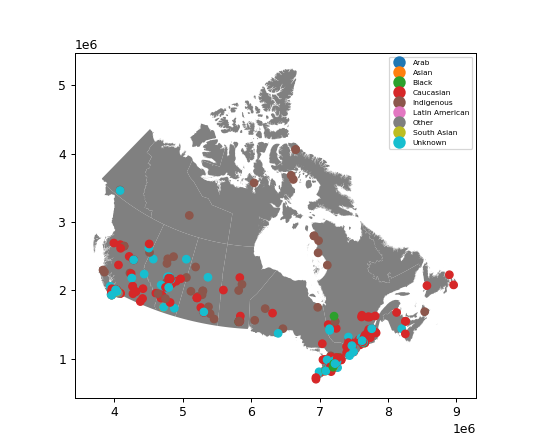

In [20]:
Canada = gpd.read_file('lpr_000b16a_e.shp')
print(Canada.crs)
police_Killings = police_Killings.to_crs(Provinces.crs)

fig,ax=plt.subplots(figsize=(6,5))
Canada.plot(ax=ax,color='grey')
police_Killings.plot(ax=ax,column='race',legend=True,legend_kwds={'loc': 'upper right','fontsize':6})

## Obvioulsly, there are more killings where there are more people.

### But does that tell the whole story?  No!

* Ontariao is the most populous province (14.5 million), and it has the most
* Quebec is the second most populous (8.5 million), yet BC (5 million) has more killings!?

In [22]:
print(police_Killings.groupby('prov').count()['date'].sort_values())

prov
NT      1
YT      2
NL      3
NS      3
NB      4
NU      5
SK     17
MB     19
AB     71
QC     87
BC     98
ON    152
Name: date, dtype: int64


# To really know what's going on, we need to Normalize our data

* Lets import a tabular dataset of provincial level census information
* We have the total population, and the racial breakdown.

In [23]:
Census = pd.read_csv('Census.csv',index_col=[0])
Census.head()

,Total,South Asian,Chinese,Black,Filipino,Latin American,Arab,Southeast Asian,West Asian,Korean,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Asian,Caucasian
PRUID,,,,,,,,,,,,,,,,
1,35151728,1924635,1577060,1198545,780125,447320,523235,313260,264305,188710,92920,132090,232375,1673780,2952075,25803368
10,519716,2645,2325,2350,1385,635,1375,335,220,75,60,145,255,45725,4180,462186
11,142907,925,2570,825,670,255,585,145,215,210,110,50,85,2735,3705,133527
12,923598,7905,8645,21910,3400,1685,8115,1195,1540,1540,695,635,1390,51490,15475,813453
13,747101,2535,3925,6995,1975,1285,2960,1230,735,1685,230,300,680,29380,9045,693186


## We can join this data set to the provincial shapefile!

* PRUID is a "unique identifier" that represents the provinces.  We can use it as the join key.

In [24]:
Test_Join = Provinces.set_index('PRUID').join(Census)
Test_Join.head()

,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,AREA_LCC,AREA_AEA,Area_Merc,geometry,Total,...,Arab,Southeast Asian,West Asian,Korean,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Asian,Caucasian
PRUID,,,,,,,,,,,,,,,,,,,,,
10,Newfoundland and Labrador,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,397598.0,406998.00,1124050.0,"MULTIPOLYGON (((8307365.589 2582136.711, 83083...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Prince Edward Island,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,6023.0,5893.29,12384.0,"MULTIPOLYGON (((8435711.754 1679935.966, 84358...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Nova Scotia,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,57534.5,55643.30,111891.0,"MULTIPOLYGON (((8470851.646 1624745.011, 84710...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,New Brunswic,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,74525.4,73050.60,154848.0,"MULTIPOLYGON (((8176224.537 1722553.460, 81762...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,Quebec,Quebec,Québec,Que.,Qc,1476350.0,1509750.00,4309780.0,"MULTIPOLYGON (((8399709.494 2261445.703, 84005...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# But our join fails!

### Why?  Lets look at the join keys from both files?  Maybe we have a datatype missmatch?

In [25]:
print(Provinces['PRUID'])
print(Census.index)


0     10
1     11
2     12
3     13
4     24
5     35
6     46
7     47
8     48
9     59
10    60
11    61
12    62
Name: PRUID, dtype: object
Int64Index([1, 10, 11, 12, 13, 24, 35, 46, 47, 48, 59, 60, 61, 62], dtype='int64', name='PRUID')


## Sure enough!  The provinces PRUID is an "object", not an integer.

* We can fix that easily and then do the join!
    * Just type 'int64' in .astype() so it matches with the other layer!

In [26]:
Provinces['PRUID'] = Provinces['PRUID'].astype('int64')
Provinces_Join = Provinces.set_index('PRUID').join(Census)
Provinces_Join.head()

,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,AREA_LCC,AREA_AEA,Area_Merc,geometry,Total,...,Arab,Southeast Asian,West Asian,Korean,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Asian,Caucasian
PRUID,,,,,,,,,,,,,,,,,,,,,
10,Newfoundland and Labrador,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,397598.0,406998.00,1124050.0,"MULTIPOLYGON (((8307365.589 2582136.711, 83083...",519716,...,1375,335,220,75,60,145,255,45725,4180,462186
11,Prince Edward Island,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,6023.0,5893.29,12384.0,"MULTIPOLYGON (((8435711.754 1679935.966, 84358...",142907,...,585,145,215,210,110,50,85,2735,3705,133527
12,Nova Scotia,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,57534.5,55643.30,111891.0,"MULTIPOLYGON (((8470851.646 1624745.011, 84710...",923598,...,8115,1195,1540,1540,695,635,1390,51490,15475,813453
13,New Brunswic,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,74525.4,73050.60,154848.0,"MULTIPOLYGON (((8176224.537 1722553.460, 81762...",747101,...,2960,1230,735,1685,230,300,680,29380,9045,693186
24,Quebec,Quebec,Québec,Que.,Qc,1476350.0,1509750.00,4309780.0,"MULTIPOLYGON (((8399709.494 2261445.703, 84005...",8164361,...,213740,62825,32405,8055,4575,9840,23040,182890,209870,6949091


## Now we  want to normalize the number of killings by population to get a rate

* We have a few more steps to go through first.
    * The police killings and census data use different abbreviations.  To do a join our dataset with the census data we'll need to assign an new abbreviaton
    * We'll us a dictionary to do this
* Then we can summarize the killings by province and join it to the Provinces_Join layer

In [28]:
# Temp['Rate'] = Temp['date']/Temp['Total']*1e4
# Temp = Temp.sort_values(by='Rate')

abr_dict = {'AB':'Alta.',
            'BC':'B.C.',
            'MB':'Man.',
            'NB':'N.B.',
            'NL':'N.L.',
            'NS':'N.S.',
            'NT':'N.W.T.',
            'NU':'Nvt.',
            'ON':'Ont.',
            'PE':'P.E.I.',
            'QC':'Que.',
            'SK':'Sask.',
            'YT':'Y.T.'
           }

police_Killings['PREABBR']=''
for prov in police_Killings.prov.unique():
    police_Killings.loc[police_Killings['prov']==prov,'PREABBR']=abr_dict[prov]

## Now we can summarize the killings by province and join it to the Provinces_Join layer
* Note Prince Edward Island doesn't have any.

In [29]:
# Joined = Canada.join(police_Killings)
Provinces_Killings=Provinces_Join.set_index('PREABBR').join(police_Killings.groupby('PREABBR').count()['id_victim'])
Provinces_Killings['id_victim']

PREABBR
N.L.        3.0
P.E.I.      NaN
N.S.        3.0
N.B.        4.0
Que.       87.0
Ont.      152.0
Man.       19.0
Sask.      17.0
Alta.      71.0
B.C.       98.0
Y.T.        2.0
N.W.T.      1.0
Nvt.        5.0
Name: id_victim, dtype: float64

### We can fix this easily using the .fillna() function

### The we can do the normalization!!

* We'll calculat the rate of police killings per ... ten thousand?
    * Divide the number of killings, by the total population.  To get the per person rate
    * Then multiply by 1 million
    * Then sort the values
    
* Then we'll plot it on a map, with a bar graph below for extra context!

KeyError: 'West Asian'

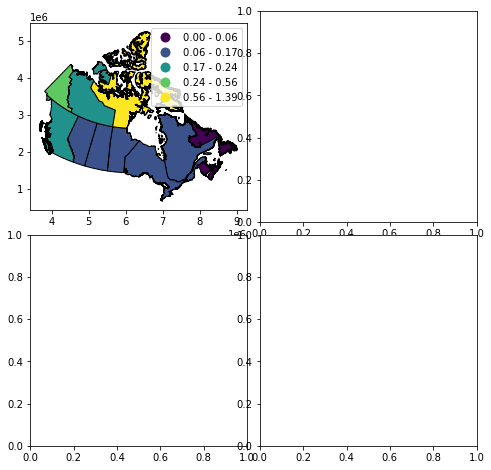

In [34]:


fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(6,6)
ax1 = fig.add_subplot(gs[0:3, :3])
ax2 = fig.add_subplot(gs[0:3, 3:])
ax3 = fig.add_subplot(gs[3:, :3])
ax4 = fig.add_subplot(gs[3:, 3:])
Provinces_Killings['Indigenous_pct'] = Provinces_Killings['Indigenous']/Provinces_Killings['Total']
Provinces_Killings['Black_pct'] = Provinces_Killings['Black']/Provinces_Killings['Total']

Provinces_Killings.plot(ax=ax1,column='Rate',edgecolor='k',legend=True,scheme='natural_breaks')
# ax3.bar(Provinces_Killings.index,Provinces_Killings['Rate'])
# ax3.set_xticklabels(Provinces_Killings.index,rotation=30)
Total = police_Killings.groupby('race').count()
Rate = []
Races = ['Black','Indigenous','Caucasian','Asian','West Asian']
for race in Races:
    Rate.append((Total['date'].T[race]/Provinces_Killings[race]).values[0]*1e6/17)
Normalized_Rates = pd.DataFrame(index=Races,data={'Rate':Rate})
ax4.bar(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k')
ax4.set_title('Police Killing Rates in BC')
ax4.set_ylabel('Killings/Year/Million Residents')
Provinces_Killings.plot(ax=ax3,column='Indigenous_pct',edgecolor='k',legend=True,scheme='natural_breaks')
Provinces_Killings.plot(ax=ax2,column='Black_pct',edgecolor='k',legend=True,scheme='natural_breaks')
plt.suptitle('Police Killing Rates Across Canada')

race
Arab                5
Black              43
Caucasian         212
East Asian         15
Indigenous         70
Latin American      3
Other               5
South Asian        10
Unknown            99
Name: date, dtype: int64
Mixed           0.232380
West Asian      0.264315
Arab            0.523235
Black           1.198545
Indigenous      1.673780
South Asian     1.924640
East Asian      2.952065
Caucasian      25.803358
dtype: float64


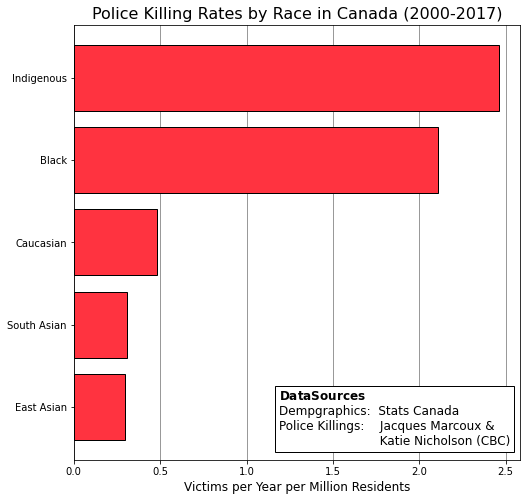

In [111]:
Provinces_Killings['East Asian']=Provinces_Killings['Asian']
police_Killings.loc[police_Killings['race']=='Asian','race']='East Asian'
Total = police_Killings.groupby('race').count()
# print(policde_killings)
print(Total['date'].T)
Rate = []


# Races = ['Black','Indigenous','Caucasian','East Asian','South Asian']

Races = ['East Asian','South Asian','Caucasian','Black','Indigenous']
for race in Races:
    Rate.append((Total['date'].T[race]/Provinces_Killings[race].sum())*1e6/17)
#     print(Total['date'].T[race])#,Provinces_Killings[race])
Normalized_Rates = pd.DataFrame(index=Races,data={'Rate':Rate})
fig,ax=plt.subplots(figsize = (8,8))
ax.barh(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k',color=[1,.2,.25],linewidth = 1)
ax.set_title("Police Killing Rates by Race in Canada (2000-2017)",fontsize = 16)
ax.set_xlabel('Victims per Year per Million Residents',fontsize=12)
ax.grid(axis='x',color='grey')
ax.set_axisbelow(True)
textstr = '$\\bf{Data Sources}$\nDempgraphics:  Stats Canada\nPolice Killings:    Jacques Marcoux &\n'+\
'                          Katie Nicholson (CBC)'
props = dict(facecolor='white')#, alpha=0.75)
ax.text(0.46, 0.16, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.savefig('Rates.png',dpi=400)
print(Provinces_Killings[['Black','Indigenous','Caucasian','East Asian','South Asian','Arab','West Asian','Mixed']].sum().sort_values()/1e6)

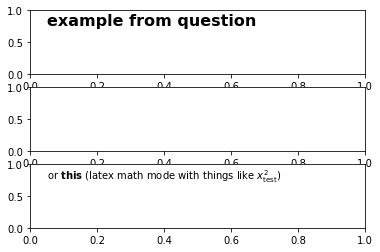

In [95]:

fig, axs = plt.subplots(3, 1)
ax0, ax1, ax2 = axs

ax0.text(0.05, 0.95, 'example from question',
        transform=ax0.transAxes, fontsize=16, fontweight='bold', va='top')
# ax1.text(0.05, 0.8, 'you can try \\textbf{this} using \\LaTeX', usetex=True,
#         transform=ax1.transAxes, fontsize=16, va='top')
ax2.text(0.05, 0.95,
         'or $\\bf{this}$ (latex math mode with things like '
         '$x_\mathrm{test}^2$)',
        transform=ax2.transAxes, fontsize=10, va='top')

plt.show()

### Nunavut obviously has a serious problem.  75% of its population is Inuit & its rate is an order of magnitude higher than the other provinces or teritories.

### BC is the worst to of the provinces.  Lets select BC and investigate further.

* For We can select BC using the PREABBR value.
* We'll also re-project into UTM Zone 10 N, this is a more accurate coordinate system for this region

* Then we can look at the racial breakdown of killings in BC using the .groupby function again.
    * We'll create a new dataframe normalizing total killings for different races by total population within those groups
    * Then we can make a barplot highlighting racial biases 


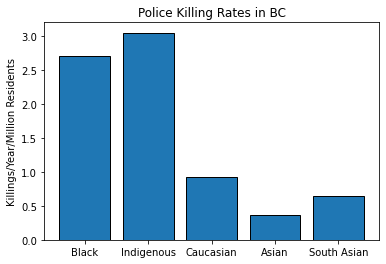

In [24]:
# 26910
BC = Provinces_Killings.loc[Provinces_Killings.index=='B.C.'].to_crs(26910)
BC_Killings = police_Killings.loc[police_Killings['PREABBR']=='B.C.'].to_crs(26910)
Total_BC = BC_Killings.groupby('race').count()

Rate = []
Races = ['Black','Indigenous','Caucasian','Asian','South Asian']
for race in Races:
    Rate.append((Total_BC['date'].T[race]/BC[race]).values[0]*1e6/17)
Normalized_Rates = pd.DataFrame(index=Races,data={'Rate':Rate})
plt.figure()
plt.bar(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k')
plt.title('Police Killing Rates in BC')
plt.ylabel('Killings/Year/Million Residents')
plt.savefig('BCPoliceKillings.png')
# print(Total_BC['Black']/BC['Black'])

# fig,ax=plt.subplots(figsize=(6,6))

# BC.plot(ax=ax,color='grey',edgecolor='k')
# BC_Killings.plot(ax=ax,column='race',legend=True)
# print(Canada.head())

# from fiona.crs import from_epsg
# from_epsg(2193)
# # Proj({'init': 'epsg:2193', 'no_defs': True}, preserve_flags=True)

## Are there any temporal trends?

* Things certainly aren't gettng any better.

<BarContainer object of 18 artists>

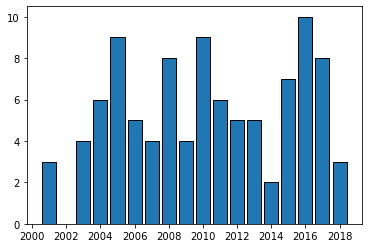

In [25]:
plt.figure()
BC_Year = BC_Killings.set_index('date').resample('Y').count()
plt.bar(BC_Year.index,BC_Year.race,width=300,edgecolor='k')

## Lets make an infographic for BC, summarizing some of the key points

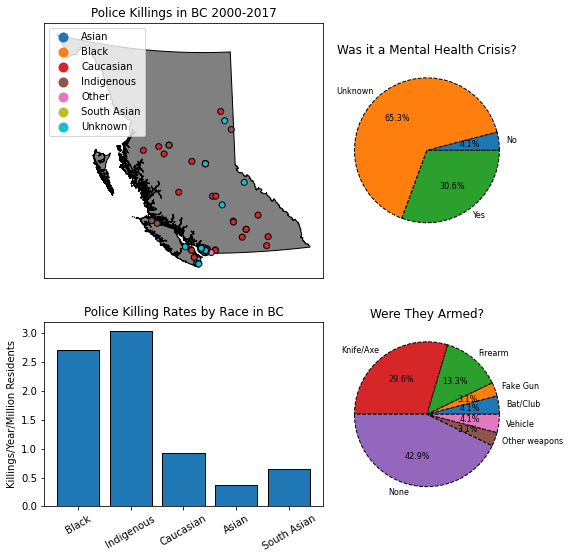

In [26]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(10,10)
ax0 = fig.add_subplot(gs[0:6, 0:6])
BC.plot(ax=ax0,color='grey',edgecolor='k')
BC_Killings.plot(ax=ax0,column='race',legend=True,edgecolor='k')
ax0.axes.get_xaxis().set_visible(False)
ax0.axes.get_yaxis().set_visible(False)
ax0.set_title('Police Killings in BC 2000-2017')


ax1 = fig.add_subplot(gs[1:5, 6:])

Mental_Health = BC_Killings.groupby('mentral_distress_disorder').count()
ax1.pie(Mental_Health['id_victim'],labels=Mental_Health.index,textprops={'fontsize': 8},
        autopct='%1.1f%%',wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'})
ax1.set_title('Was it a Mental Health Crisis?')
# ax1.bar(BC_Year.index,BC_Year.race,width=300,edgecolor='k')
# ax1.set_title('Police Killings by Year in BC')
# ax1.set_ylabel('Number')

ax2 = fig.add_subplot(gs[6:, 0:6])
ax2.bar(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k')
ax2.set_title('Police Killing Rates by Race in BC')
ax2.set_ylabel('Killings/Year/Million Residents')
ax2.set_xticklabels(Normalized_Rates.index,rotation=30)

BC_Killings.loc[BC_Killings.armed_type=='Knife, axe, other cutting instruments','armed_type']='Knife/Axe'
BC_Killings.loc[BC_Killings.armed_type=='Bat, club, other swinging object','armed_type']='Bat/Club'
BC_Killings.loc[BC_Killings.armed_type=='Air gun, replica gun','armed_type']='Fake Gun'
BC_Killings.loc[BC_Killings.armed_type=='Unknown','armed_type']='None'
Mental_Health = BC_Killings.groupby('armed_type').count()
ax3 = fig.add_subplot(gs[6:, 6:])
ax3.pie(Mental_Health['id_victim'],labels=Mental_Health.index,textprops={'fontsize': 8},
        autopct='%1.1f%%',wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'})
ax3.set_title('Were They Armed?')


plt.tight_layout()
# ax0 = fig.add_subplot(gs[0:6, 0:6])

In [218]:

police_Killings.groupby('armed_type').count()
# Canada['PREABBR']
# Joined = Canada.join(police_Killings)

,date,day_week,prov,city_town,postal_code,location_type,id_victim,Name,age,gender,...,injured_officer,excited_delirium,mentral_distress_disorder,substance_abuse,summary,latitude,longitude,geocoding_Notes,geometry,PREABBR
armed_type,,,,,,,,,,,,,,,,,,,,,
"Air gun, replica gun",27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,0,27,27
"Bat, club, other swinging object",20,20,20,20,20,20,20,20,19,20,...,20,20,20,20,20,20,20,0,20,20
Firearm,88,88,88,88,88,88,88,88,87,88,...,88,88,88,88,88,86,86,2,88,88
"Knife, axe, other cutting instruments",153,153,153,153,153,153,153,153,151,153,...,153,153,153,153,153,153,153,0,153,153
None,116,116,116,116,116,116,116,116,115,116,...,116,116,116,116,116,115,115,1,116,116
Other weapons,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,0,12,12
Unknown,23,23,23,23,23,23,23,23,21,23,...,23,23,23,23,23,22,22,1,23,23
Vehicle,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,0,23,23


In [115]:
Temp = police_Killings.groupby('PREABBR').count()['date']
Temp = Canada.set_index('PREABBR').join(Temp)
# print(Canada.head())

<IPython.core.display.Javascript object>


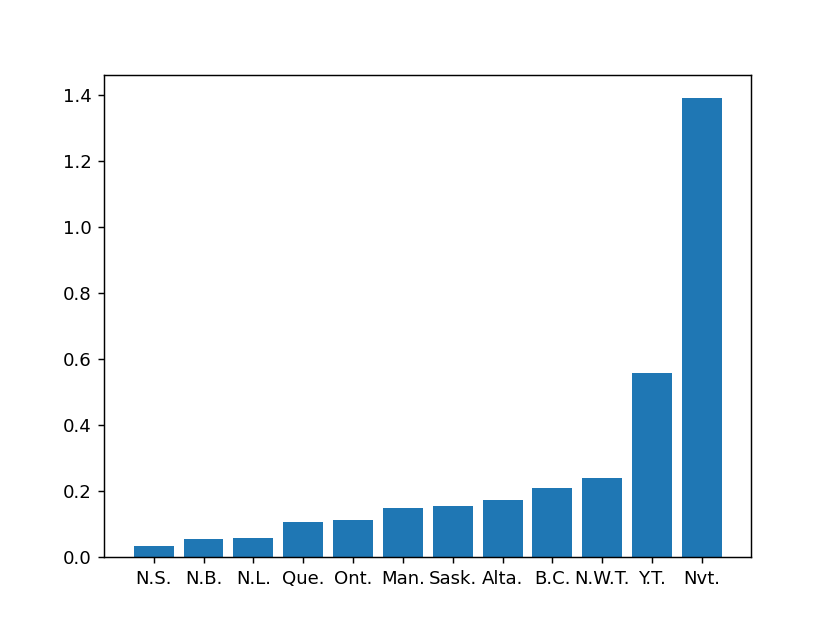

<BarContainer object of 13 artists>

In [120]:
Temp['Rate'] = Temp['date']/Temp['Total']*1e4
Temp = Temp.sort_values(by='Rate')
plt.figure()
plt.bar(Temp.index,Temp['Rate'])

<IPython.core.display.Javascript object>


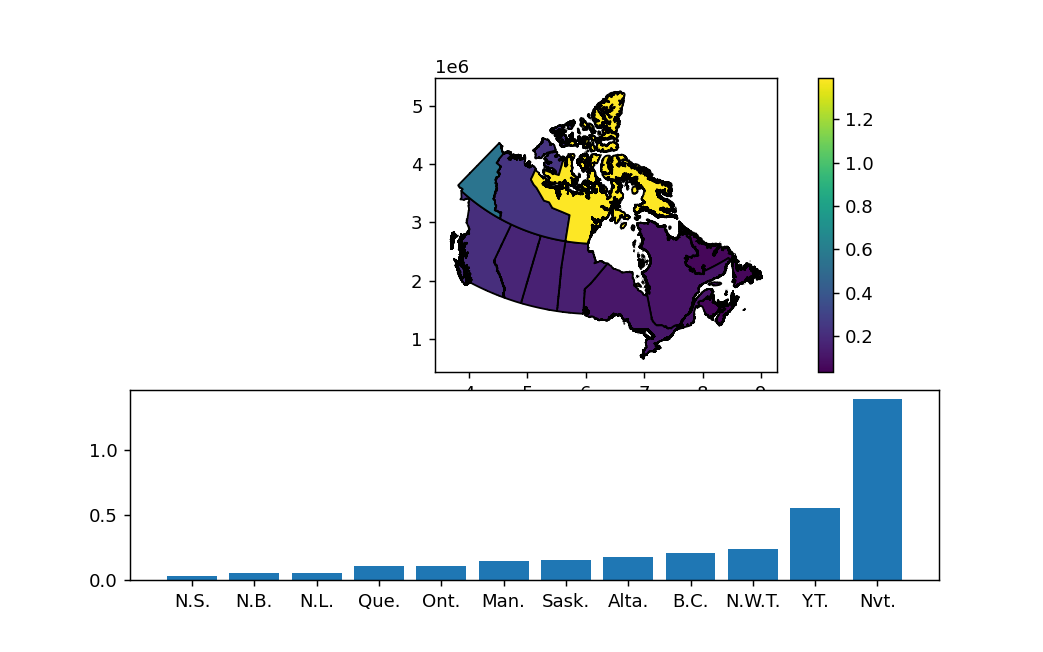

<BarContainer object of 13 artists>

In [145]:
fig = plt.figure(figsize=(8,5))

gs = fig.add_gridspec(5,2)
ax1 = fig.add_subplot(gs[0:3, :])

Temp.plot(ax=ax1,column='Rate',edgecolor='k',legend=True)
# BC_Killings.plot(ax=ax,column='race',legend=True)
ax3 = fig.add_subplot(gs[3:, :])
ax3.bar(Temp.index,Temp['Rate'])

# plt.subplot(2, 2, 4)
# plt.plot(x, np.sin(x)*np.cos(x))